## Part 1 - EDA

* Loading Libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , StratifiedKFold , cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score , roc_auc_score 
from scipy.stats import chisquare

- Reading the data, checking its shape and glimpsin at it

In [2]:
data = pd.read_csv("data/german_credit_data.csv")

In [3]:
print(data.shape)
data.head()

(1000, 10)


,age,sex,job,housing,saving_account,checking_account,credit_amount,duration,purpose,target
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


- We right away see we have NaN values in the data, and we have relatively small data set with 1000 rows and 9 features.

- Checking the type of each column in the data, some are numeric and some are strings that we would deal later.

In [4]:
data.dtypes

age                  int64
sex                 object
job                  int64
housing             object
saving_account      object
checking_account    object
credit_amount        int64
duration             int64
purpose             object
target              object
dtype: object

- Checking if our "target" variable is balanced, we see that not so much with 70% are good and the rest are bad. Because the 
    target isnt overly imbalanced, we will use stratified kfolds when training and splitting our models.
- Besides, giving that information we have a good baseline metric result we want to beat for "accuracy" that is 70%, meaning if       we just guess all the time "good" we will get 70% accuracy, so we want our models to beat that.
- This imbalance also suggest we should also use another metric such as roc_auc.

In [5]:
data["target"].value_counts(normalize = True)

good    0.7
bad     0.3
Name: target, dtype: float64

- Looking at different metrics of our numeric features - we take 2 main points out of this: First we see that the numeric    features doesnt have any NaN. Second each of them beside "credit_amount" is more like level/categorical feature and "credit_amount" is more continuous, so we should look at his distribution.

In [6]:
data.describe()

,age,job,credit_amount,duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


- Checking NaN for each of our variables: We see that we only have them in "saving_account" and "checking_account" features and with large amount. because of the context of this dataset and the amount of NaN (18% and 40%) we assume the NaN is a category that reflects the fact that the person doesnt have any of this accounts, so we changed the NaN accordinly

In [7]:
data.isna().sum()

age                   0
sex                   0
job                   0
housing               0
saving_account      183
checking_account    394
credit_amount         0
duration              0
purpose               0
target                0
dtype: int64

- Changing the NaN to "don't have"

In [8]:
data.fillna("don't have" , inplace=True)

- Checking how many categories are there for each feature, later we will convert this with one-hot encoder.

In [9]:
data.select_dtypes(include="object").nunique()

sex                 2
housing             3
saving_account      5
checking_account    4
purpose             8
target              2
dtype: int64

### Plots

- Becuase "credit amount" was the only continuous feature, we will look at his distribution to see what or if its required to engineer this feature.

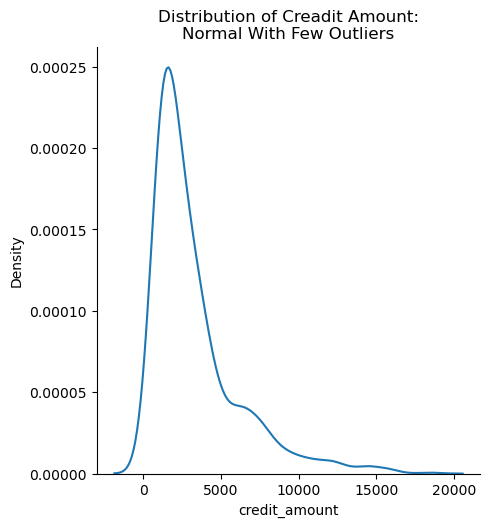

In [10]:
dist_plt_credit = sns.displot(data , x = "credit_amount" , kind = "kde")
dist_plt_credit.set(title = "Distribution of Creadit Amount:\nNormal With Few Outliers")


- We can see that "credit_amount" is fairly noraml distributed with a few outliers, so we will normalize this feature before fitting any models.

- The next plot shows for each "purpose" the percentage of each "sex" that applied for that purpose. for instance 24% of females that applied to furniture/equipment vs 16% of males. This plot shows in general the difference between males and females in terms of applying for a loan.

[Text(0.5, 1.0, 'Differences of Purposes Between Males and Females:\nThe Percentage Out of Each Sex'),
 Text(0.5, 0, 'Percentage of Sex'),
 Text(0, 0.5, 'Purpose')]

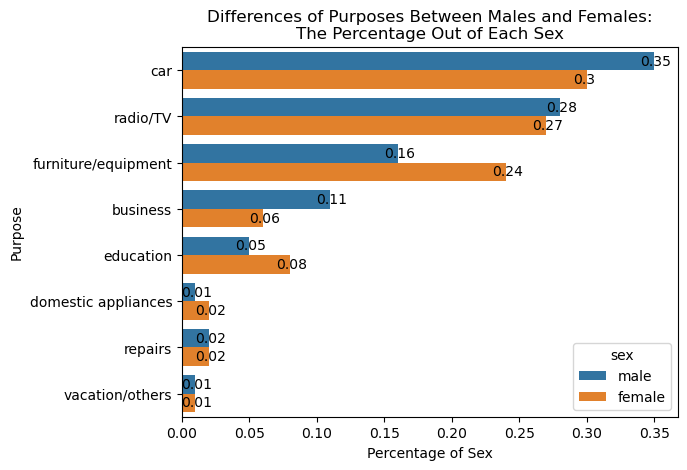

In [11]:
purpose_by_sex = data.groupby(['sex', 'purpose']).size().reset_index(name='counts')
purpose_by_sex['proportions'] = purpose_by_sex.groupby('sex' , group_keys=False)['counts'].apply(lambda x: x / x.sum()).round(2)
purpose_by_sex = purpose_by_sex.sort_values("proportions" ,ascending=False)

perc_per_sex = sns.barplot(data= purpose_by_sex , y = "purpose" , x = "proportions" , hue = "sex")
for i in perc_per_sex.containers:
    perc_per_sex.bar_label(i, label_type='edge', padding=-10)

perc_per_sex.set(title = "Differences of Purposes Between Males and Females:\nThe Percentage Out of Each Sex" ,
                xlabel= "Percentage of Sex" , ylabel="Purpose")

- The next plot checked if there is a bias between males and females in terms of who get good score. This plot shows the percentage of good "target" out of those who applied for a loan. We can see that execpt education, more percentage of males got good rating then females, meaning it is more easy to label good for males then females.

[Text(0.5, 1.0, 'Out of Those who Apply, How\nMany Labeld as Good'),
 Text(0.5, 0, 'Percentage of Good'),
 Text(0, 0.5, 'Purpose')]

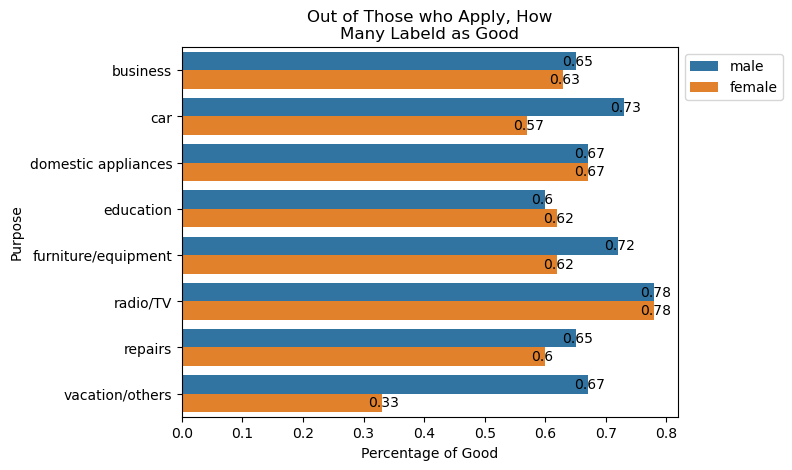

In [12]:
target_by_sex_purpose = pd.crosstab(index=[data["sex"] , data["purpose"]] , columns= data["target"] , normalize="index").reset_index()
target_by_sex_purpose["good"] = target_by_sex_purpose["good"].round(2)  

perc_sex_target = sns.barplot(data= target_by_sex_purpose , y = "purpose" , x = "good" , hue = "sex" ,
                             hue_order=["male" , "female"])
perc_sex_target.legend(bbox_to_anchor = (1,1))
for i in perc_sex_target.containers:
    perc_sex_target.bar_label(i, label_type='edge', padding=-10)
    
perc_sex_target.set(title = "Out of Those who Apply, How\nMany Labeld as Good" ,
                   xlabel= "Percentage of Good" , ylabel= "Purpose")

- The next plot shoes the relationship between "credit_amount" and "age", divided by "sex" and colored by "target". we can see that for higher credit there isnt a better chance at getting "good" rating, and the "bad" rating is occuring all over the "age" distribution.

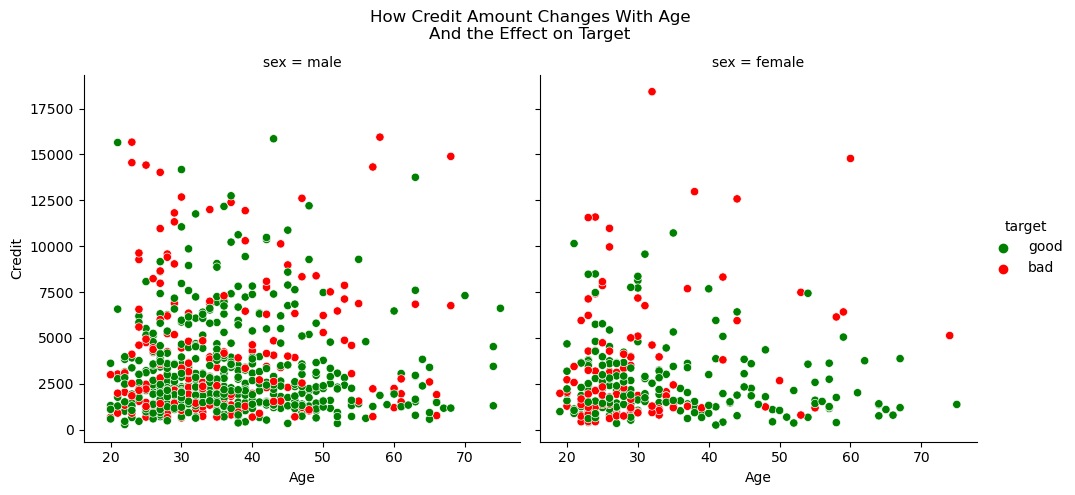

In [13]:
credit_age = sns.relplot(
        data=data, x="age", y="credit_amount",
        col="sex", hue="target",
        kind="scatter" ,
        palette= ["green" , "red"]
    )
credit_age.fig.subplots_adjust(top = 0.85)
credit_age.fig.suptitle("How Credit Amount Changes With Age\nAnd the Effect on Target")
credit_age.set(xlabel = "Age" , ylabel = "Credit")

- The next plot shows which sex is better financly responsible in terms of "saving_account", and if its affect the rating. we can see that men have "little" saving even as thay get older, but even more than that they dont have saving account even if they get older, in the other hand much less women dont have saving account as they get older.
- Further more we can see that for women the number of bad rating is pretty close to the number of good rating when dividing by age and bank account, when for men this isnt the case. This suggest that the combination of this feature are important to the rating.

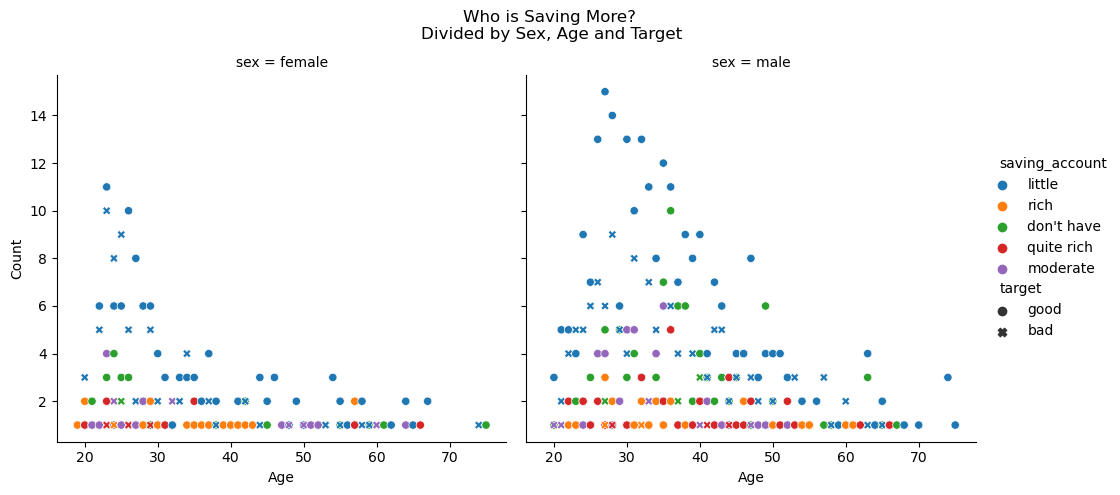

In [14]:
grouped_for_savings = data.groupby(["sex" , "age" , "saving_account" , "target"] , as_index = False).size()

saving_age = sns.relplot(
    data=grouped_for_savings, x="age", y="size",
    col="sex", hue="saving_account" , style = "target", style_order=["good" , "bad"],
    kind="scatter"
)

saving_age.fig.subplots_adjust(top = 0.85)
saving_age.fig.suptitle("Who is Saving More? \nDivided by Sex, Age and Target")
saving_age.set(xlabel = "Age" , ylabel = "Count")

- The next plot shown the affect of the comination of "job" and "housing" regarding the rating. The main conclusion from this plot is that the "job" feature could be not important. We can see this by observing the ratio of bad and good rating for each "job", which stays pretty much the same for all of them. We will check this later when we will calculate the correlation of all the "job" levels with the "target" after applying one-hot encoding.
- On the other hand we can see that "housing" is good indication for the rating, this beacuse we see the ratio between owning a house is in favor of good rating much more than the other levels: free and rent.

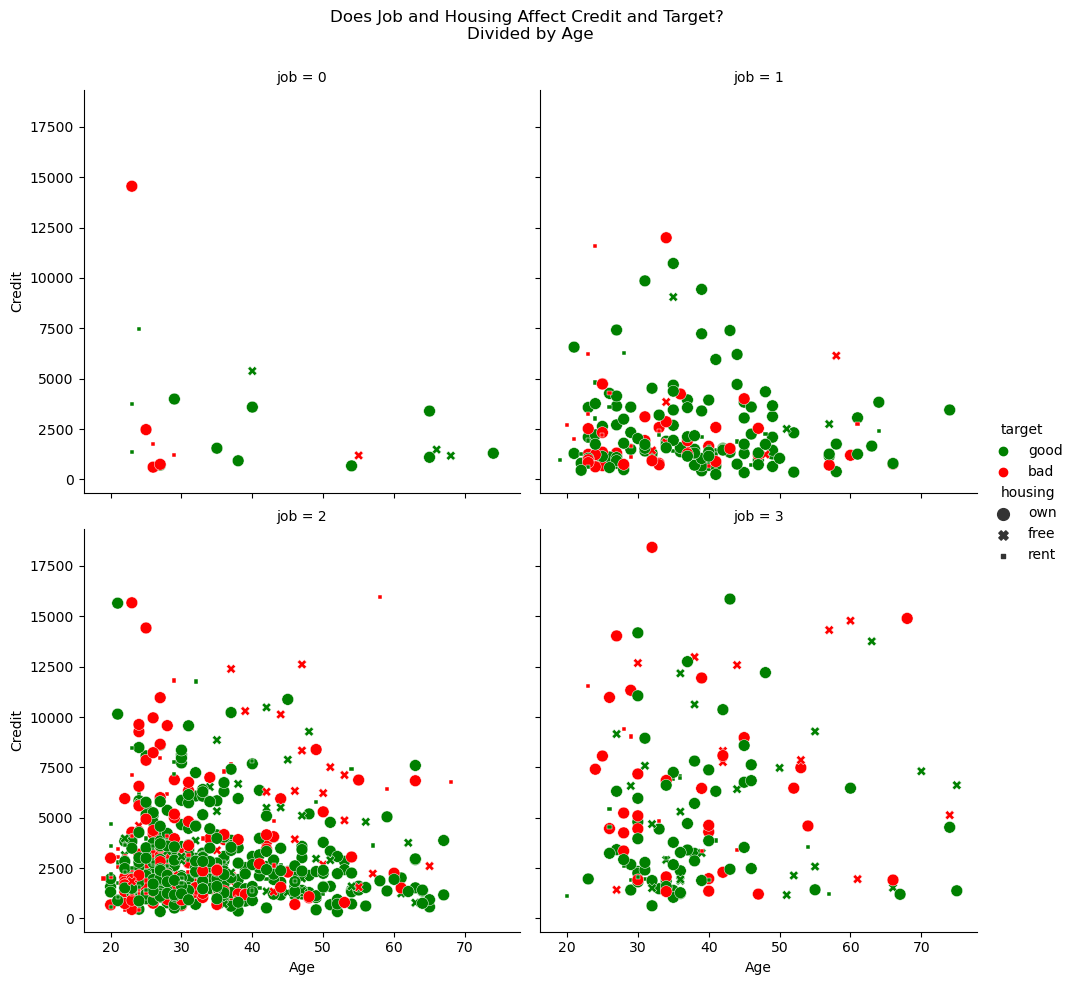

In [15]:
job_credit_age = sns.relplot(
        data=data, x="age", y="credit_amount",
        col="job", hue="target" ,
        style = "housing", size = "housing",
        kind="scatter", col_wrap=2 ,
        palette= ["green" , "red"]
    )

job_credit_age.fig.subplots_adjust(top = 0.9)
job_credit_age.fig.suptitle("Does Job and Housing Affect Credit and Target? \nDivided by Age")
job_credit_age.set(xlabel = "Age" , ylabel = "Credit")

- This plot shows the differences of "duration" for each "purpose". naturally purposes that required more that will have higher duraion of load. we also look at the "target" variable to see if longer loans have more bad or good rating.
- We see that generally the higher the "duration" the higher the chance to get bad rating, regardless of the purpose.

[Text(0.5, 1.0, 'Does Purposes Have Different Durations? \nHow Banks Looks at Duration'),
 Text(0.5, 0, 'Duration'),
 Text(0, 0.5, 'Purpose')]

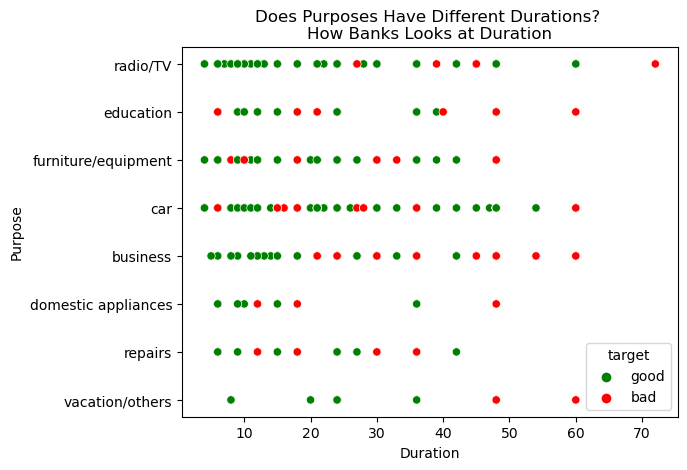

In [16]:
duration_purpose = sns.scatterplot(data=data , x = "duration" , y = "purpose" , hue = "target" , palette=["green" , "red"])

duration_purpose.set(title = "Does Purposes Have Different Durations? \nHow Banks Looks at Duration" ,
                    xlabel = "Duration" , ylabel = "Purpose")

- Lastly we look at the combination of "saving_account" and "checking_account", and try to see which is more important in order to get good rating. We see that "saving_account" in more important, by observing the number of good ratings in the little saving account row, we see that even if you dont have checking account you will probably get a good rating. This is the same for all other levels of "saving_account".

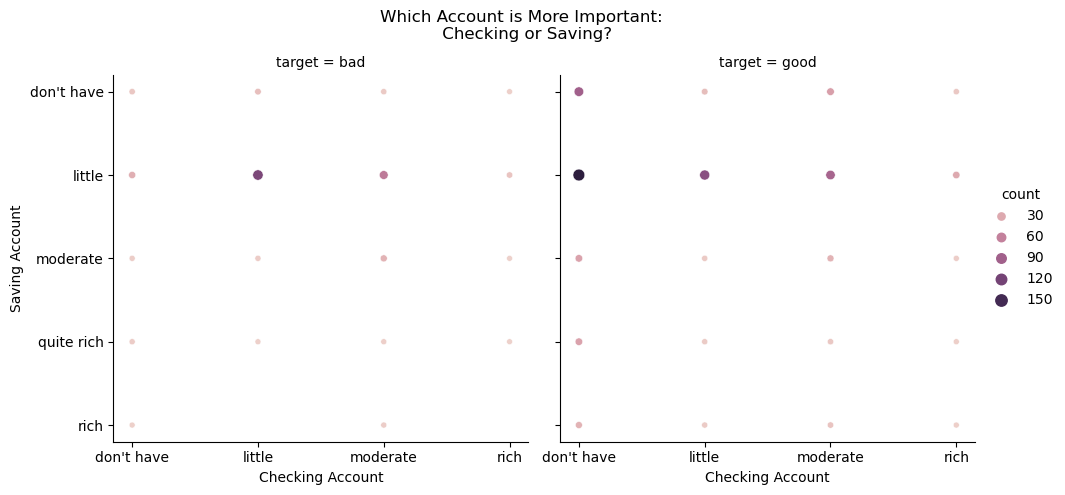

In [17]:
checking_by_saving = data.groupby(["saving_account" , "checking_account" , "target"] , as_index=False).count()[["age","saving_account" , "checking_account" , "target"]]
checking_by_saving.rename(columns={"age":"count"} , inplace=True)

saving_checking = sns.relplot(
        data=checking_by_saving, x="checking_account", y="saving_account",
        col="target", hue="count" , size = "count",
        kind="scatter"
    )

saving_checking.fig.subplots_adjust(top = 0.85)
saving_checking.fig.suptitle("Which Account is More Important: \n Checking or Saving?")
saving_checking.set(xlabel = "Checking Account" , ylabel = "Saving Account")

- To make sure both accounts are important, we will use chi square test on each one. this beacuse their intersection doesnt have enough values in order to use the test.
- We will define H0 for each test as the acccount and the target have no association, meaning they are statistically independent. H1 will be defined as otherwise.

- First we make for each account dataframe containing the count for good and bad:

In [21]:
saving_target_count = data.groupby(["saving_account" , "target"]).agg(value = ("target" , "count"))
saving_target_count = saving_target_count.pivot_table(index = "saving_account" , columns="target")
saving_target_count

value     
target           bad good
saving_account           
don't have        32  151
little           217  386
moderate          34   69
quite rich        11   52
rich               6   42

In [27]:
checking_target_count = data.groupby(["checking_account" , "target"]).agg(value = ("target" , "count"))
checking_target_count = checking_target_count.pivot_table(index = "checking_account" , columns="target")
checking_target_count

value     
target             bad good
checking_account           
don't have          46  348
little             135  139
moderate           105  164
rich                14   49

In [31]:
chi_t_saving , p_value_saving = chisquare(saving_target_count , axis = None)
chi_t_checking , p_value_checking = chisquare(checking_target_count , axis = None)
print(f"Saving account chi2 p-value : {p_value_saving} \nChecking account chi2 p-value: {p_value_checking}")

Saving account chi2 p-value : 3.2677037246828366e-275 
Checking account chi2 p-value: 1.493954834737106e-127


- As we can see, in both chi squared test we reject H0, and thus conclude that both account features have association with the target variable

- Conclusion: we saw that all the feature besides "job" can affect the "target" variable and its rating, when combining features together. We will make sure this is the case when we calculate the correlation of the features with "target" after applying one-hot encoding, and look at the "job" levels correlation.

## Part 2 - Feature engineering

### feature engineering tasks

We already dealt with NaN in the data, so what left to do is the following:

- encoding sex to 1/0 when 1 is male
- one-hot encoding housing 
- one-hot encoding pupropse
- one-hot encoding saving_account
- one-hot encoding checking_account
- normalize credit amount
- encode the target to 1/0 when 1 is good

For handeling the "duration" feature we will use 2 approaches and use cross-validation to see which one works better:
Due to duration context means the months for a loan, and with it ranges between 4 and 72 months, one approach is to cut his values for some categories and then onehot encode them. the second approach is to leave the feature as it is.

First we will deal with all the other features

In [18]:
data["sex"].replace(["male" , "female"] , [1,0] , inplace = True)
data["target"].replace(["good" , "bad"] , [1,0] , inplace = True)
data = pd.get_dummies(data , columns=["housing" , "purpose" , "saving_account" , "checking_account" ,"job"])
data["credit_amount"] = (data["credit_amount"] - data["credit_amount"].mean()) / data["credit_amount"].std()

- Notice we used k levels for each categorical feature, this because in the next section we want to compute correlation for all levels in each feature with the target variable
- Before dealing with the "duration" feature, we can see what correlates with the target variable the most and drop features if needed. We can do this now after encoding all our categorical features and understand the meaning clearly.

[Text(0.5, 1.0, 'Correlation With Target')]

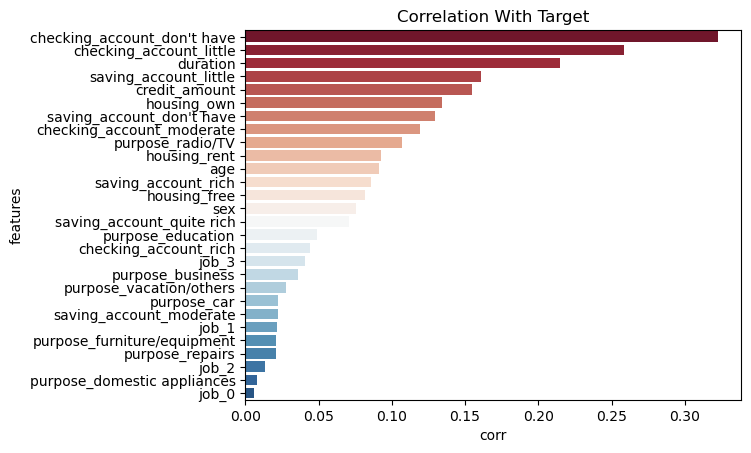

In [19]:
var_importance = data.corrwith(data["target"]).abs()
var_importance = var_importance.sort_values(ascending=False).reset_index().rename(columns={"index":"features" , 0 :"corr"})
var_importance.drop(index=var_importance.index[0], axis=0, inplace=True)
sns.barplot(data = var_importance , y = "features" , x = "corr" , palette= sns.color_palette("RdBu", 29)).set(title = "Correlation With Target")

- Few thing we take away from this plot: 
    - First we see that all levels of "job" feature are poorly correlated with the "target" variable. We saw this at the EDA part when we looked at the job plot, and assumed this is the case. Thus we will drop all the "job" levels from the data
    - Both "saving_account" and "checking_account" have strong correlation with the "target" on most levels, and we saw a hint to that when we performed chi squared test on both of them.
    - Furthermore in order to use k-1 levels for each categorical feature, we will drop the least correlated level out of this feature

In [20]:
data.drop(columns=["job_1" , "job_2" , "job_3" , "job_0" , "purpose_domestic appliances" , "saving_account_moderate" ,
                  "checking_account_rich" , "housing_free"] , inplace=True)

- Now for the "duration" feature. In order to use cross-validation between the 2 approaches when dealing with this feature, we need to make 2 datasets to use each time in cross-validation. This is what we make here, we copy the data and divide the feature to 9 levels, when each levels defines a period of 6 months of load duration, when the lest level is for loans longer than 48 months. After doing this we one-hot encode the feature.

In [21]:
data_duration_cut = data.copy()
cutting_duration_list = [0,6,12,18,24,30,36,42,48,72]
labels_for_cutted_duration = ["under 6 months" , "between 6 and 12" , "between 12 and 18" , "between 18 and 24" ,
                             "between 24 and 30" , "between 30 and 36" , "between 36 and 42" , "between 42 and 48" ,
                             "over 48 months"]
data_duration_cut["duration"] = pd.cut(data_duration_cut["duration"] , cutting_duration_list , labels= labels_for_cutted_duration)
data_duration_cut = pd.get_dummies(data_duration_cut , columns=["duration"] , drop_first=True)

## Part 3 and 4 - cross validation for model choosing and evaluating 

- Splitting each of the datasets to training set and testing set using stratified train_test_split in order to preserve and 70-30 balanced in the target. We will meet the test data only in the end after choosing the best model when we will perform cross-validation on the training data. our training data will have 800 rows and the test data will have 200 rows.
- Note that we used the same random_state for the cut and the uncut datasets, so both of them splitted the same way.

In [22]:
X , y = data.loc[: , data.columns != "target"] , data["target"]
X_train , X_test , y_train  , y_test = train_test_split(X ,y , test_size=0.2 , random_state=42 , stratify=y)

X_cut , y_cut = data_duration_cut.loc[: , data_duration_cut.columns != "target"] , data_duration_cut["target"]
X_train_cut , X_test_cut , y_train_cut  , y_test_cut = train_test_split(X_cut ,y_cut , test_size=0.2 , random_state=42 , 
                                                                       stratify=y_cut)

- Definind the method of cross-validation. We will use strarified kfold with 4 splits so each time our validation data will be the same size as the test data in the end, meaning 200 rows
- After that we define our models - Logistic regression, decistion tree with splitting criterion of "gini" and another tree with splitting criterion of "entropy". For each tree we define the min_sample_split to be 10, meaning a node will be able to split only if he has 10 or more samples.

In [23]:
skf = StratifiedKFold(n_splits=4 , shuffle=True , random_state=42)
clf_logistic = LogisticRegression(max_iter=500)
tree_gini = DecisionTreeClassifier(criterion="gini" , min_samples_split=10 , random_state=42)
tree_entropy = DecisionTreeClassifier(criterion="entropy" , min_samples_split=10 , random_state=42)

#### Performing the cross-validation on the dataset with no "duration" cut.

- Performing the method for each model. Note that when we defined the stratifiedkfold we passed it a random_state, and because of this each split of the data during cross-validation is the same split accros all models, so all of them train exactly on the same data each iteration of the cross-validation.
- Because of don't have balanced target, we will look also at the roc_auc metric for each model.

In [24]:
scores = ["accuracy" , "roc_auc"]
logistic_scores = cross_validate(clf_logistic , X_train , y_train , cv = skf , scoring=scores)
tree_gini_scores = cross_validate(tree_gini , X_train , y_train , cv = skf , scoring=scores)
tree_entropy_scores = cross_validate(tree_entropy , X_train , y_train , cv = skf , scoring=scores)

In [25]:
print(logistic_scores["test_accuracy"].mean().round(4) , logistic_scores["test_accuracy"].std().round(4))
print(logistic_scores["test_roc_auc"].mean().round(4) , logistic_scores["test_roc_auc"].std().round(4))

0.7275 0.0115
0.7527 0.0135


In [26]:
print(tree_gini_scores["test_accuracy"].mean().round(4) , tree_gini_scores["test_accuracy"].std().round(4))
print(tree_gini_scores["test_roc_auc"].mean().round(4) , tree_gini_scores["test_roc_auc"].std().round(4))

0.6838 0.021
0.6535 0.0066


In [27]:
print(tree_entropy_scores["test_accuracy"].mean().round(4) , tree_entropy_scores["test_accuracy"].std().round(4))
print(tree_entropy_scores["test_roc_auc"].mean().round(4) , tree_entropy_scores["test_roc_auc"].std().round(4))

0.6862 0.0265
0.6581 0.036


- For the dataset with no cutting "duration" we got:
    - Logistic regression - 0.7275 accuracy with 0.0115 std , 0.7527 roc_auc with 0.0135 std
    - Tree with "gini" - 0.6838 accuracy with 0.021 std , 0.6535 roc_auc with 0.0066 std
    - Tree with "entropy" - 0.6862 accuracy with 0.0265 std , 0.6581 roc_auc with 0.036 std

#### Performing the cross-validation on the dataset with "duration" cut.

- We use the same strarifiedkfold object to make sure the training set is splitted the same way as before

In [28]:
skf = StratifiedKFold(n_splits=4 , shuffle=True , random_state=42)
clf_logistic = LogisticRegression(max_iter=500)
tree_gini = DecisionTreeClassifier(criterion="gini" , min_samples_split=10 ,random_state=42)
tree_entropy = DecisionTreeClassifier(criterion="entropy" , min_samples_split=10 , random_state=42)

In [29]:
logistic_scores = cross_validate(clf_logistic , X_train_cut , y_train_cut , cv = skf , scoring=scores)
tree_gini_scores = cross_validate(tree_gini , X_train_cut , y_train_cut , cv = skf , scoring=scores)
tree_entropy_scores = cross_validate(tree_entropy , X_train_cut , y_train_cut , cv = skf , scoring=scores)

In [30]:
print(logistic_scores["test_accuracy"].mean().round(4) , logistic_scores["test_accuracy"].std().round(4))
print(logistic_scores["test_roc_auc"].mean().round(4) , logistic_scores["test_roc_auc"].std().round(4))

0.735 0.0127
0.7382 0.016


In [31]:
print(tree_gini_scores["test_accuracy"].mean().round(4) , tree_gini_scores["test_accuracy"].std().round(4))
print(tree_gini_scores["test_roc_auc"].mean().round(4) , tree_gini_scores["test_roc_auc"].std().round(4))

0.6762 0.0225
0.6435 0.029


In [32]:
print(tree_entropy_scores["test_accuracy"].mean().round(4) , tree_entropy_scores["test_accuracy"].std().round(4))
print(tree_entropy_scores["test_roc_auc"].mean().round(4) , tree_entropy_scores["test_roc_auc"].std().round(4))

0.6762 0.0082
0.6476 0.0356


- For the dataset with cut "duration" we got:
    - Logistic regression - 0.735 accuracy with 0.0127 std , 0.7382 roc_auc with 0.016 std
    - Tree with "gini" - 0.6762 accuracy with 0.0225 std , 0.6435 roc_auc with 0.029 std
    - Tree with "entropy" - 0.6762 accuracy with 0.0082 std , 0.6476 roc_auc with 0.0365 std

- Conclusion: The best model we have is logistic regression on the dataset when we dont cut the "duration" feature. Thus we chose also the model and also the preproccessing step. the model got 0.7275 accuracy with 0.0115 std , 0.7527 roc_auc with 0.0135 std.
- Note: Although this model didnt got the best accuracy, which the logistic model for the cutted data got, the results were very close and the chosen model got lower std. Plus becuase the target variable isn't balanced we looked also at the roc_auc, which the chosen model had the best

### Fitting the model on the entire training set and getting final estimation on the test set

- In order to see we dont overfit, we will also comapter the metrics on the training data

In [33]:
clf_logistic = LogisticRegression(max_iter=500 , random_state=42)
clf_logistic.fit(X_train , y_train)
y_pred = clf_logistic.predict(X_train)
print(accuracy_score(y_train , y_pred))
print(roc_auc_score(y_train , y_pred))

0.745
0.6440476190476191


In [34]:
clf_logistic = LogisticRegression(max_iter=500 , random_state=42)
clf_logistic.fit(X_train , y_train)
y_pred = clf_logistic.predict(X_test)
print(accuracy_score(y_test , y_pred))
print(roc_auc_score(y_test , y_pred))

0.75
0.6642857142857143


- We didnt overfit to the training data, and got 75% accuracy on the test data and 66 roc_auc.
- This results are made up mainley becuase we have small training data - only 800 rows. If we had more we probably get much more better results and our model will generalize better on unseen data.